In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import matthews_corrcoef,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/approved/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/train-csv/train (5).csv
/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


In [2]:
train_csv='/kaggle/input/playground-series-s4e10/train.csv'
train_csv2='/kaggle/input/approved/credit_risk_dataset.csv'
test_csv='/kaggle/input/playground-series-s4e10/test.csv'

In [3]:
train_csv=pd.read_csv(train_csv,nrows=20000,index_col=0)
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,27,60000,RENT,4.0,EDUCATION,A,10000,7.51,0.17,N,8,0
19996,25,51000,MORTGAGE,3.0,EDUCATION,E,16750,16.40,0.33,Y,4,0
19997,28,48000,MORTGAGE,1.0,MEDICAL,A,4800,5.42,0.10,N,7,0


In [4]:
train_cv2=pd.read_csv(train_csv2)
train_cv2

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [5]:
print(type(train_csv2))

<class 'str'>


In [6]:
train_csv=pd.concat([train_csv,train_cv2],axis=0)

In [7]:
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [8]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  52581 non-null  int64  
 1   person_income               52581 non-null  int64  
 2   person_home_ownership       52581 non-null  object 
 3   person_emp_length           51686 non-null  float64
 4   loan_intent                 52581 non-null  object 
 5   loan_grade                  52581 non-null  object 
 6   loan_amnt                   52581 non-null  int64  
 7   loan_int_rate               49465 non-null  float64
 8   loan_percent_income         52581 non-null  float64
 9   cb_person_default_on_file   52581 non-null  object 
 10  cb_person_cred_hist_length  52581 non-null  int64  
 11  loan_status                 52581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.2+ MB


In [9]:
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52581.000000,5.258100e+04,51686.000000,52581.000000,49465.000000,52581.000000,52581.000000,52581.000000
mean,27.640288,6.533759e+04,4.741922,9453.660105,10.885107,0.166157,5.792815,0.190620
std,6.217896,5.479029e+04,4.040399,6045.883032,3.162867,0.101380,4.038082,0.392794
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.220000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
for i in train_csv:
    print(i)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status


In [11]:
def seperation_func(data):
    cont_var=[]
    cat_var=[]
    for i in data.columns:
        if data[i].dtype=='int64'or data[i].dtype=='float64':
            cont_var.append(i)
        else:
            cat_var.append(i)
    return cont_var,cat_var    

In [12]:
cont_var,cat_var=seperation_func(train_csv)

In [13]:
cont_var

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_status']

In [14]:
def plotdist(data,cont):
    for i in cont:
        fig,ax=plt.subplots(1,2,figsize=(10,9))
        sns.histplot(data[i],bins='doane',ax=ax[0])
        ax[0].set_title('Histogram')
        ax[0].set_xlabel(f'{i}')
        ax[0].set_ylabel('count')
        sns.violinplot(data,x=data[i],ax=ax[1])
        ax[1].set_xlabel(f'{i}')
        ax[1].set_title('Voilinplot')
        plt.tight_layout()
        plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


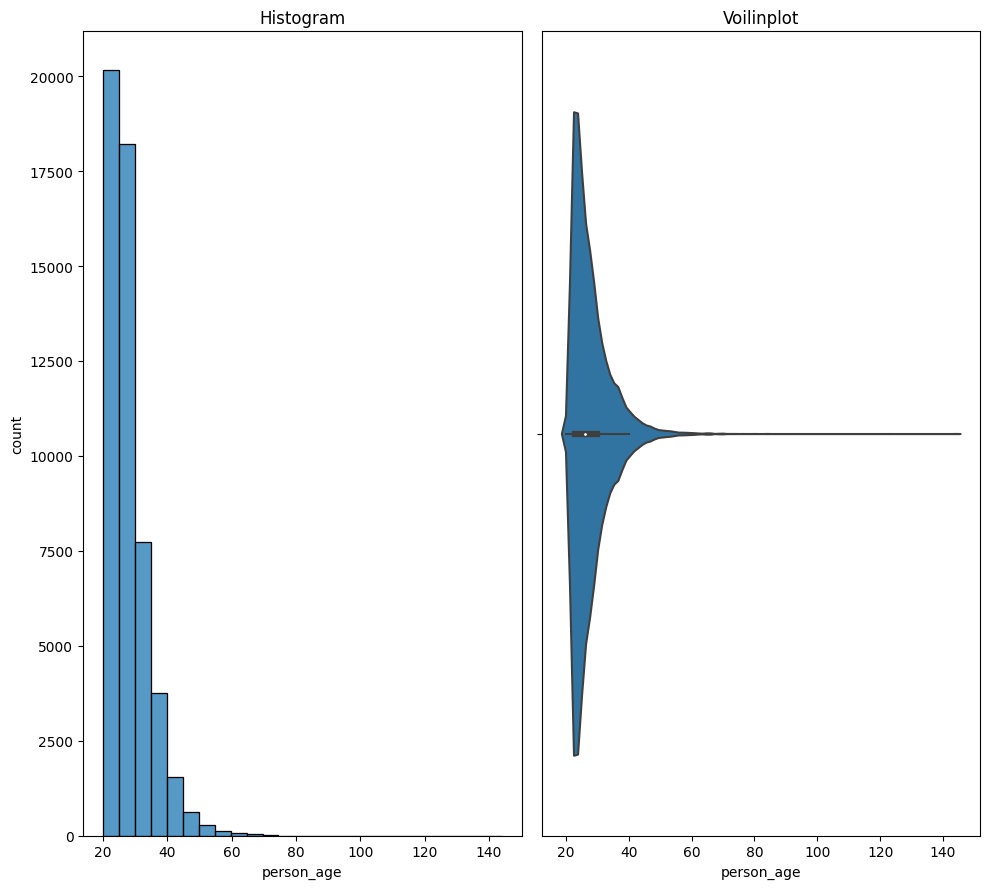

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


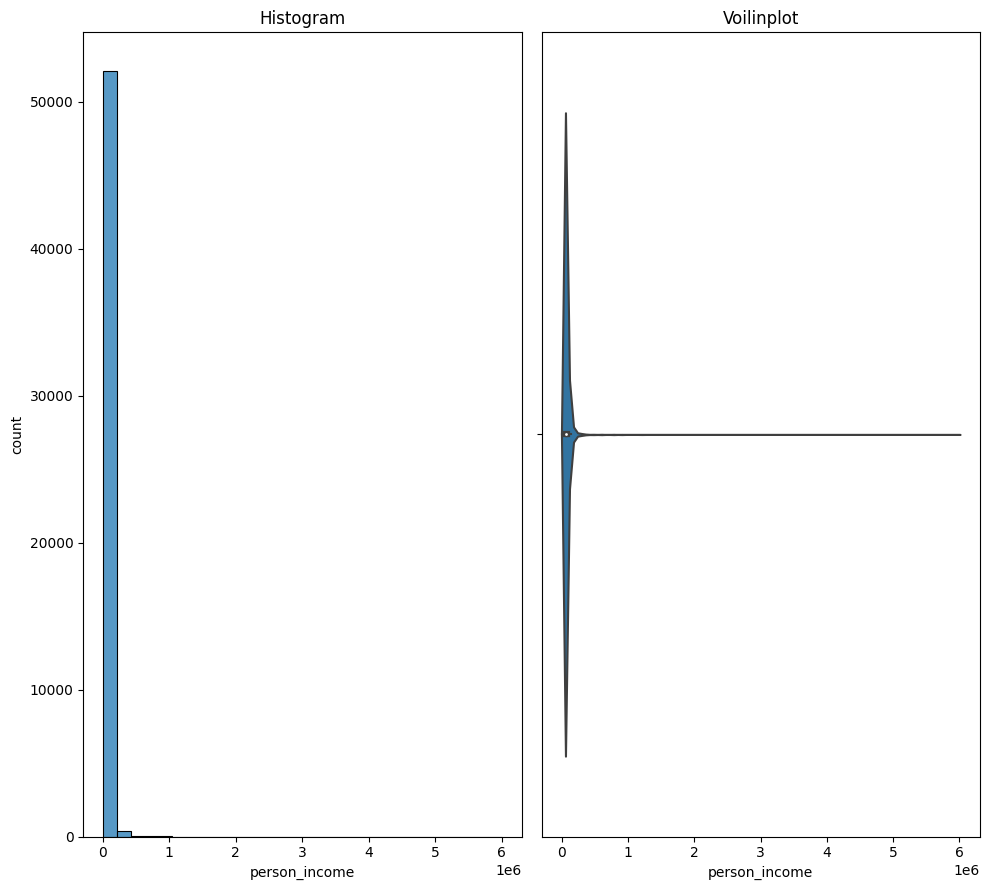

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


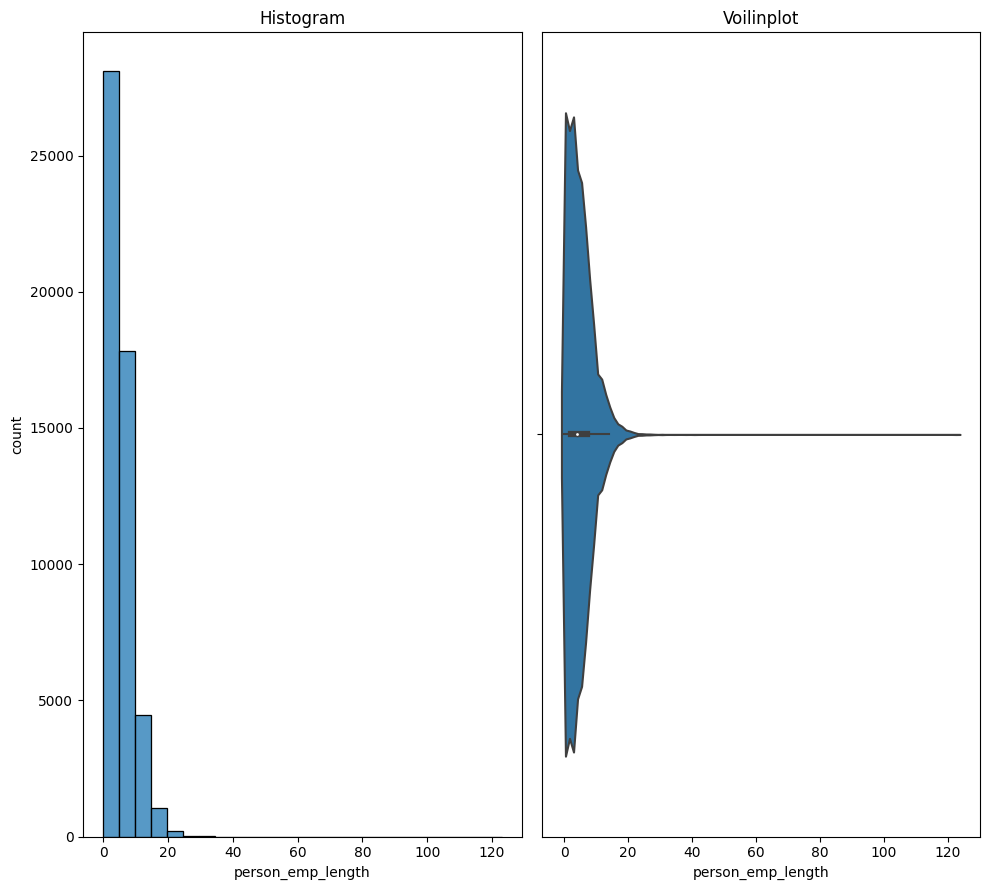

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


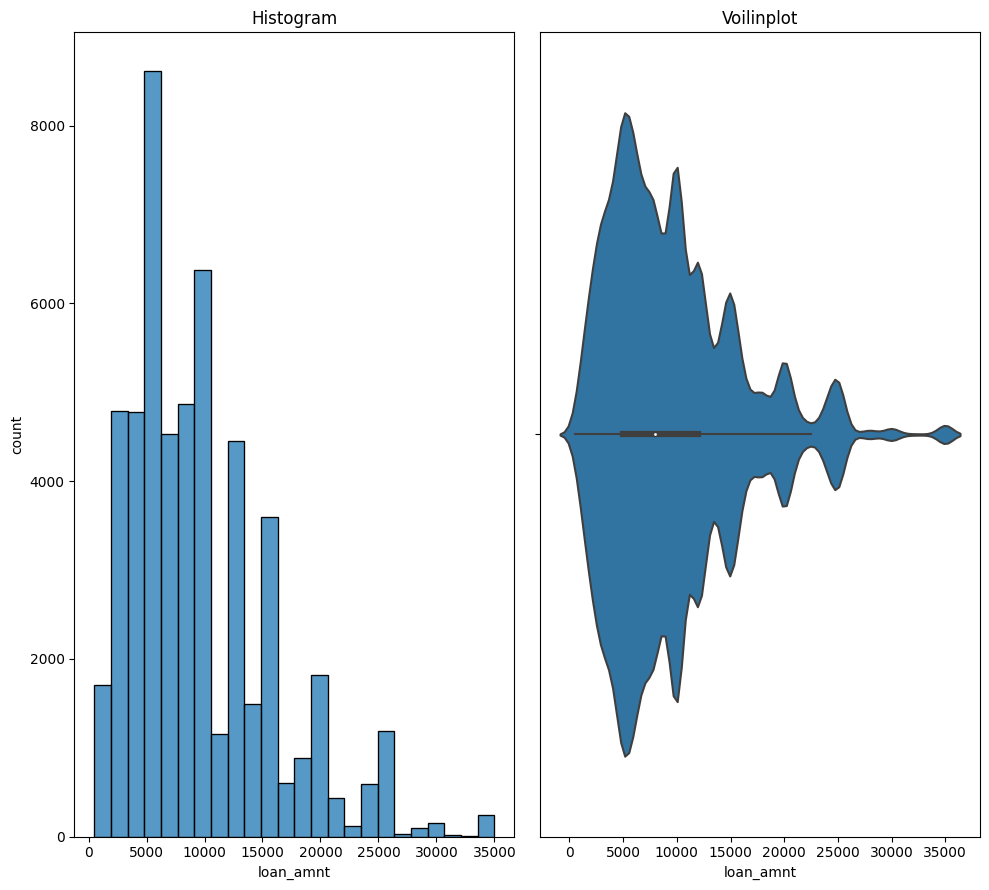

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


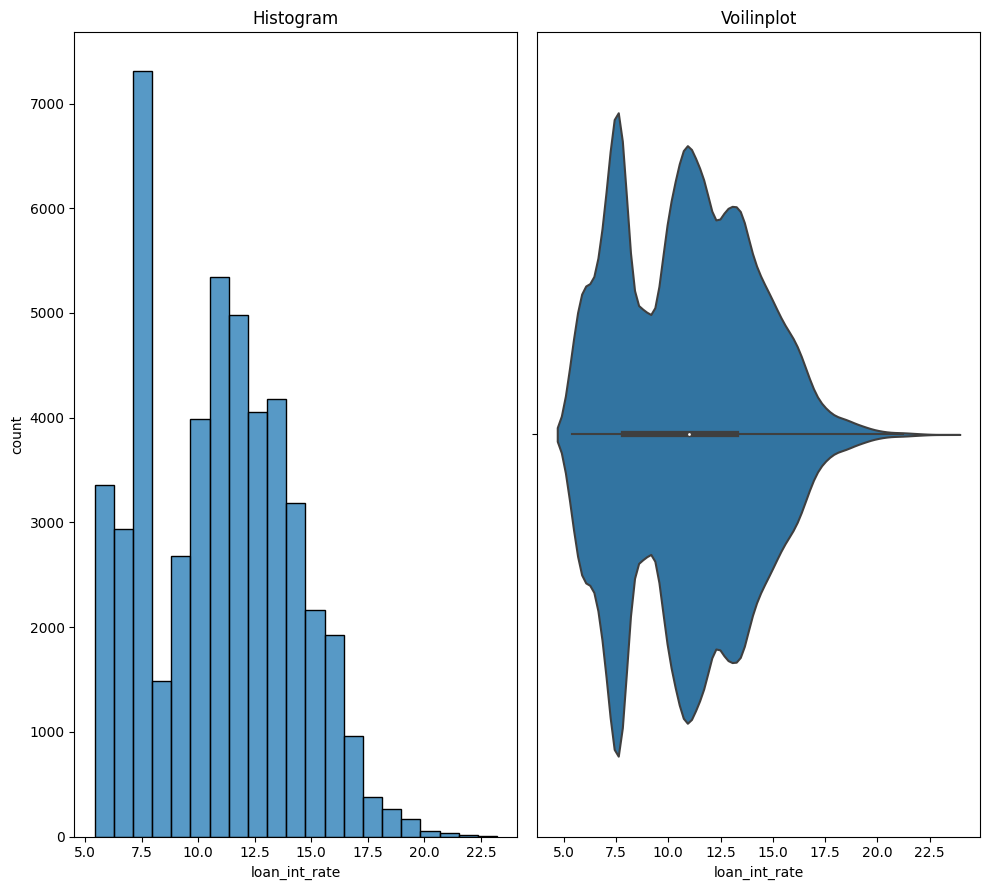

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


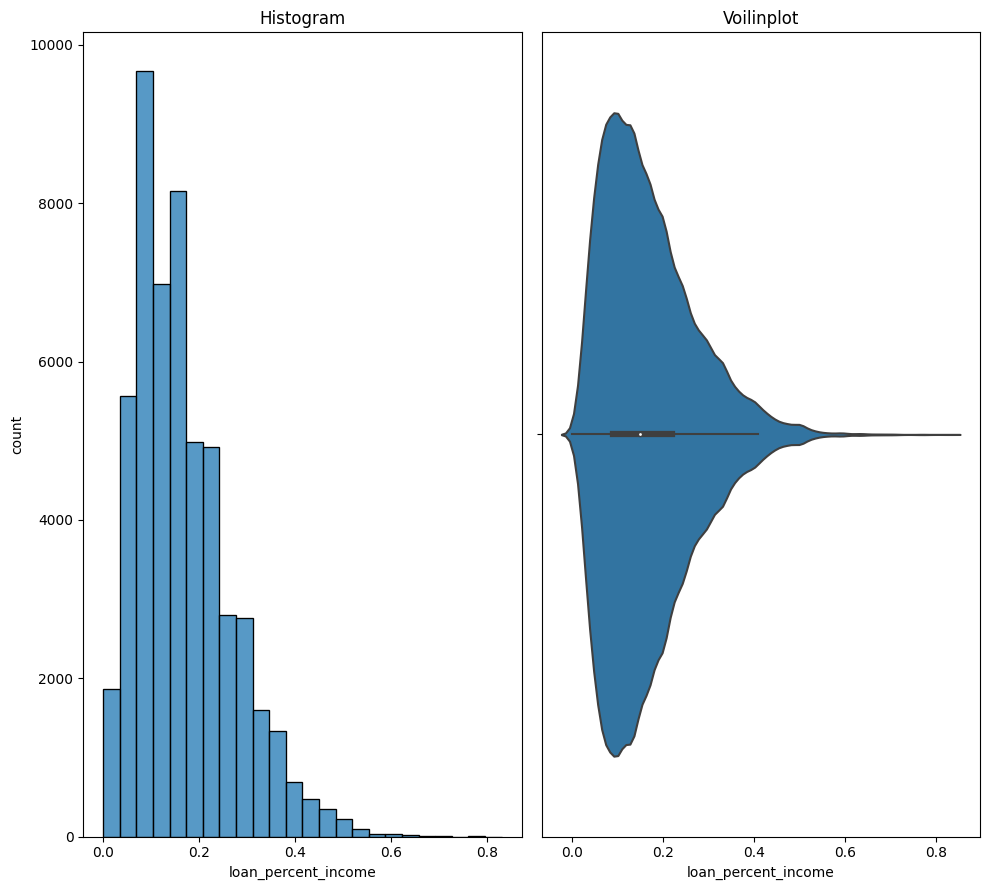

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


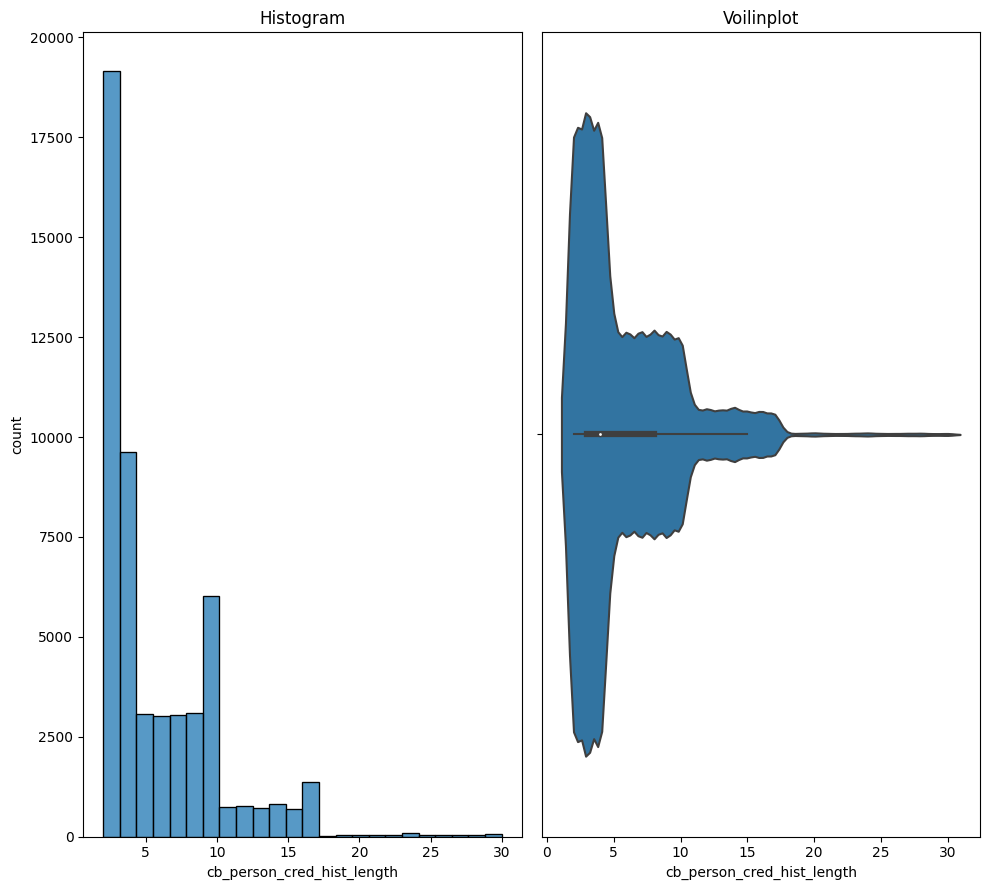

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


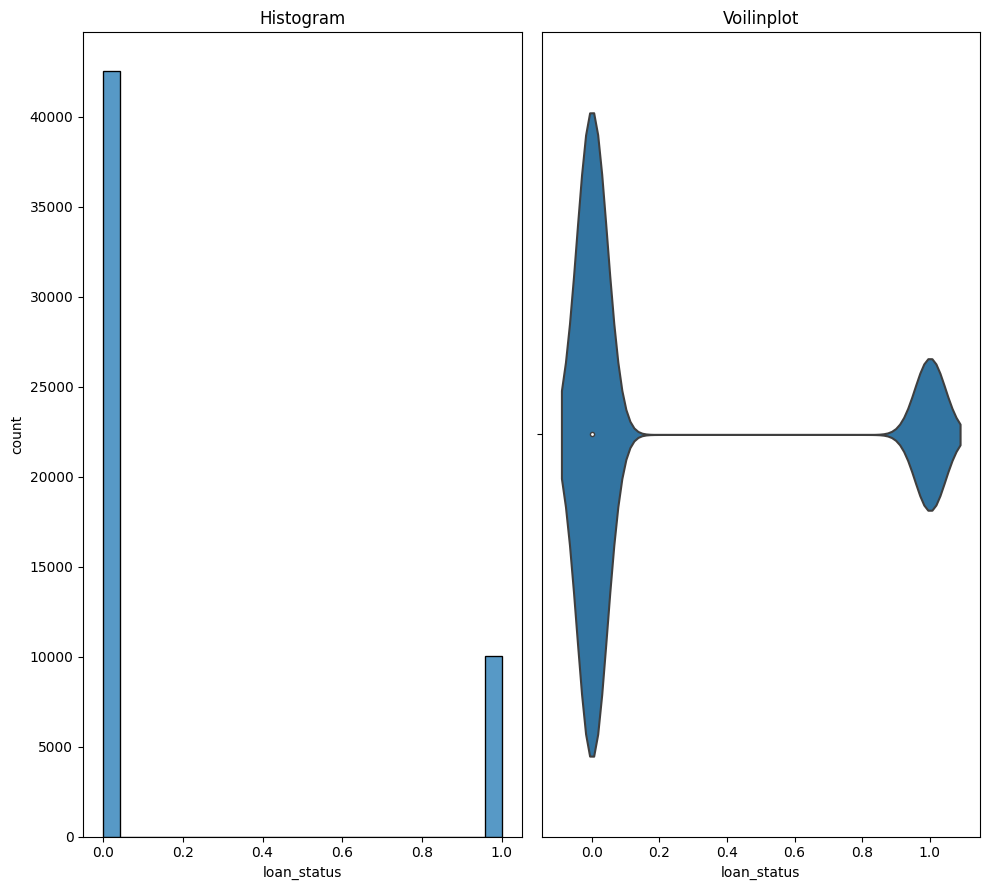

In [15]:
plotdist(train_csv,cont_var)

In [16]:
copy_data=train_csv.copy(deep=True)

## Checking Imbalance Dataset

([<matplotlib.patches.Wedge at 0x7c022ed0b670>,
 [Text(-0.9085822474887384, 0.6200631415818175, '0'),
  Text(0.9085822474887381, -0.620063141581818, '1')],
 [Text(-0.4955903168120391, 0.3382162590446277, '80.9%'),
  Text(0.4955903168120389, -0.338216259044628, '19.1%')])

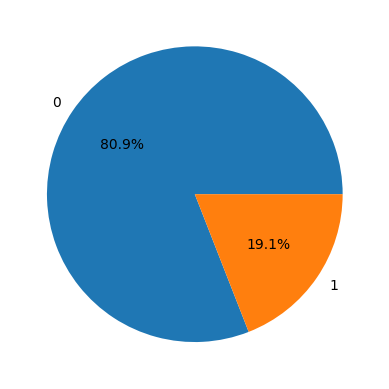

In [17]:
count_class=train_csv['loan_status'].value_counts()
plt.pie(labels=[0,1],x=count_class,autopct='%1.1f%%' )

In [18]:
print(len(train_csv['person_age']>40))

52581


In [19]:
train_csv['person_income']=np.log(train_csv['person_income']+1)
train_csv['loan_amnt']=np.log(train_csv['loan_amnt']+1)

In [20]:
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52581.000000,52581.000000,51686.000000,52581.000000,49465.000000,52581.000000,52581.000000,52581.000000
mean,27.640288,10.937362,4.741922,8.942502,10.885107,0.166157,5.792815,0.190620
std,6.217896,0.527667,4.040399,0.685582,3.162867,0.101380,4.038082,0.392794
min,20.000000,8.294300,0.000000,6.216606,5.420000,0.000000,2.000000,0.000000
25%,23.000000,10.596660,2.000000,8.517393,7.880000,0.090000,3.000000,0.000000
50%,26.000000,10.933125,4.000000,8.987322,10.990000,0.150000,4.000000,0.000000
75%,30.000000,11.264477,7.000000,9.392745,13.220000,0.220000,8.000000,0.000000
max,144.000000,15.607270,123.000000,10.463132,23.220000,0.830000,30.000000,1.000000


In [21]:
def removeoutliers(data,cont):
    q1=data[cont].quantile(0.25)
    q3=data[cont].quantile(0.75)
    IQR=q3-q1
    lower_bound=q1-1.5*IQR
    upper_bound=q3+4.0*IQR
    filtered_data=data[cont].where((data[cont]>lower_bound)&(data[cont]<upper_bound),other=np.nan)
    return filtered_data

In [22]:
for i in cont_var:
    if i=='loan_status':
        continue
    train_csv[i]=removeoutliers(train_csv,i)

In [23]:
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52413.000000,52116.000000,51661.000000,51852.000000,49465.000000,52576.000000,52485.0000,52581.000000
mean,27.517925,10.950152,4.726002,8.970254,10.885107,0.166099,5.7505,0.190620
std,5.787748,0.505922,3.936253,0.648763,3.162867,0.101206,3.9184,0.392794
min,20.000000,9.602450,0.000000,7.208600,5.420000,0.000000,2.0000,0.000000
25%,23.000000,10.596660,2.000000,8.517393,7.880000,0.090000,3.0000,0.000000
50%,26.000000,10.937152,4.000000,8.987322,10.990000,0.150000,4.0000,0.000000
75%,30.000000,11.267038,7.000000,9.392745,13.220000,0.220000,8.0000,0.000000
max,57.000000,13.762111,26.000000,10.463132,23.220000,0.720000,27.0000,1.000000


In [24]:
train_csv[cont_var]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,37.0,10.463132,0.0,8.699681,11.49,0.17,14.0,0
1,22.0,10.933125,6.0,8.294300,13.35,0.07,2.0,0
2,29.0,10.268165,8.0,8.699681,8.90,0.21,10.0,0
3,30.0,11.156265,14.0,9.392745,11.11,0.17,5.0,0
4,22.0,11.002117,2.0,8.699681,6.92,0.10,3.0,0
...,...,...,...,...,...,...,...,...
32576,57.0,10.878066,1.0,8.665786,13.16,0.11,NaN,0
32577,54.0,11.695255,4.0,9.777130,7.49,0.15,19.0,0
32578,NaN,11.238502,3.0,10.463132,10.99,0.46,NaN,1
32579,56.0,11.918397,5.0,9.615872,11.48,0.10,26.0,0


In [25]:
train_csv.dropna(inplace=True)

In [26]:
train_csv.shape
train_csv.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000,47473.000000
mean,27.495166,10.959059,4.747793,8.979274,10.892374,0.166365,5.710699,0.183388
std,5.702169,0.499367,3.928947,0.643150,3.154922,0.099126,3.818975,0.386989
min,20.000000,9.602450,0.000000,7.208600,5.420000,0.000000,2.000000,0.000000
25%,23.000000,10.596660,2.000000,8.517393,7.880000,0.090000,3.000000,0.000000
50%,26.000000,10.950824,4.000000,8.987322,10.990000,0.150000,4.000000,0.000000
75%,30.000000,11.277216,7.000000,9.392745,13.220000,0.220000,8.000000,0.000000
max,57.000000,13.762111,26.000000,10.463132,23.220000,0.720000,27.000000,1.000000


In [27]:
for i in cat_var:
    print(train_csv[i].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']
['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
['B' 'C' 'A' 'D' 'E' 'F' 'G']
['N' 'Y']


In [28]:
house_status=['RENT', 'OWN', 'MORTGAGE', 'OTHER']
status=['EDUCATION', 'MEDICAL' ,'PERSONAL' ,'VENTURE', 'DEBTCONSOLIDATION','HOMEIMPROVEMENT']
grade=['B', 'C', 'A', 'D', 'E', 'F', 'G']
house_status=list(zip(house_status,range(1,len(house_status)+1)))
status=list(zip(status,range(1,len(status)+1)))
grade=list(zip(grade,range(1,len(grade)+1)))
print(grade)

[('B', 1), ('C', 2), ('A', 3), ('D', 4), ('E', 5), ('F', 6), ('G', 7)]


In [29]:
house_status={value: index for value,index in house_status}
status={value: index for value,index in status}
grade={value: index for value,index in grade}
print(grade)

{'B': 1, 'C': 2, 'A': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}


In [30]:
train_csv['person_home_ownership']=train_csv['person_home_ownership'].map(house_status)
train_csv['loan_intent']=train_csv['loan_intent'].map(status)
train_csv['loan_grade']=train_csv['loan_grade'].map(grade)

In [31]:
train_csv[cat_var]

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,1,1,1,N
1,2,2,2,N
2,2,3,3,N
3,1,4,1,N
4,1,2,3,N
...,...,...,...,...
32573,3,3,3,N
32574,1,3,4,Y
32575,1,1,1,N
32577,3,3,3,N


In [32]:
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37.0,10.463132,1,0.0,1,1,8.699681,11.49,0.17,N,14.0,0
1,22.0,10.933125,2,6.0,2,2,8.294300,13.35,0.07,N,2.0,0
2,29.0,10.268165,2,8.0,3,3,8.699681,8.90,0.21,N,10.0,0
3,30.0,11.156265,1,14.0,4,1,9.392745,11.11,0.17,N,5.0,0
4,22.0,11.002117,1,2.0,2,3,8.699681,6.92,0.10,N,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32573,56.0,11.407576,3,0.0,3,3,8.881975,6.17,0.08,N,19.0,0
32574,52.0,11.082219,1,4.0,3,4,9.903538,15.58,0.31,Y,19.0,1
32575,52.0,11.074436,1,0.0,1,1,8.517393,11.26,0.08,N,20.0,0
32577,54.0,11.695255,3,4.0,3,3,9.777130,7.49,0.15,N,19.0,0


In [33]:
train_csv = pd.get_dummies(train_csv, columns=['cb_person_default_on_file'])
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,37.0,10.463132,1,0.0,1,1,8.699681,11.49,0.17,14.0,0,True,False
1,22.0,10.933125,2,6.0,2,2,8.294300,13.35,0.07,2.0,0,True,False
2,29.0,10.268165,2,8.0,3,3,8.699681,8.90,0.21,10.0,0,True,False
3,30.0,11.156265,1,14.0,4,1,9.392745,11.11,0.17,5.0,0,True,False
4,22.0,11.002117,1,2.0,2,3,8.699681,6.92,0.10,3.0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32573,56.0,11.407576,3,0.0,3,3,8.881975,6.17,0.08,19.0,0,True,False
32574,52.0,11.082219,1,4.0,3,4,9.903538,15.58,0.31,19.0,1,False,True
32575,52.0,11.074436,1,0.0,1,1,8.517393,11.26,0.08,20.0,0,True,False
32577,54.0,11.695255,3,4.0,3,3,9.777130,7.49,0.15,19.0,0,True,False


In [34]:
train_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,37.0,10.463132,1,0.0,1,1,8.699681,11.49,0.17,14.0,0,True,False
1,22.0,10.933125,2,6.0,2,2,8.294300,13.35,0.07,2.0,0,True,False
2,29.0,10.268165,2,8.0,3,3,8.699681,8.90,0.21,10.0,0,True,False
3,30.0,11.156265,1,14.0,4,1,9.392745,11.11,0.17,5.0,0,True,False
4,22.0,11.002117,1,2.0,2,3,8.699681,6.92,0.10,3.0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32573,56.0,11.407576,3,0.0,3,3,8.881975,6.17,0.08,19.0,0,True,False
32574,52.0,11.082219,1,4.0,3,4,9.903538,15.58,0.31,19.0,1,False,True
32575,52.0,11.074436,1,0.0,1,1,8.517393,11.26,0.08,20.0,0,True,False
32577,54.0,11.695255,3,4.0,3,3,9.777130,7.49,0.15,19.0,0,True,False


## interaction effect

In [35]:
train_csv['loan_grade*loan_int_rate']=train_csv['loan_grade']*train_csv['loan_int_rate']
train_csv['loan_percent_income*loan_amnt']=train_csv['loan_percent_income']*train_csv['loan_amnt']
train_csv['person_income*loan_int_rate']=train_csv['person_income']*train_csv['loan_int_rate']
train_csv['person_emp_length*loan_int_rate']=train_csv['person_emp_length']*train_csv['loan_int_rate']
train_csv['person_emp_length*loan_grade']=train_csv['person_emp_length']*train_csv['loan_grade']
train_csv['person_home_ownership*person_income']=train_csv['person_home_ownership']*train_csv['person_income']
train_csv['cb_person_cred_hist_length*loan_grade']=train_csv['cb_person_cred_hist_length']*train_csv['loan_grade']
train_csv['loan_percent_income*loan_grade']=train_csv['loan_percent_income']*train_csv['loan_grade']
train_csv['loan_int_rate*loan_amnt']=train_csv['loan_int_rate']*train_csv['loan_amnt']
train_csv['person_emp_length*person_income']=train_csv['person_emp_length']*train_csv['person_income']
train_csv['person_age*person_emp_length']=train_csv['person_emp_length']*train_csv['person_age']


In [36]:
cont_var,cat_var=seperation_func(train_csv)

<Axes: >

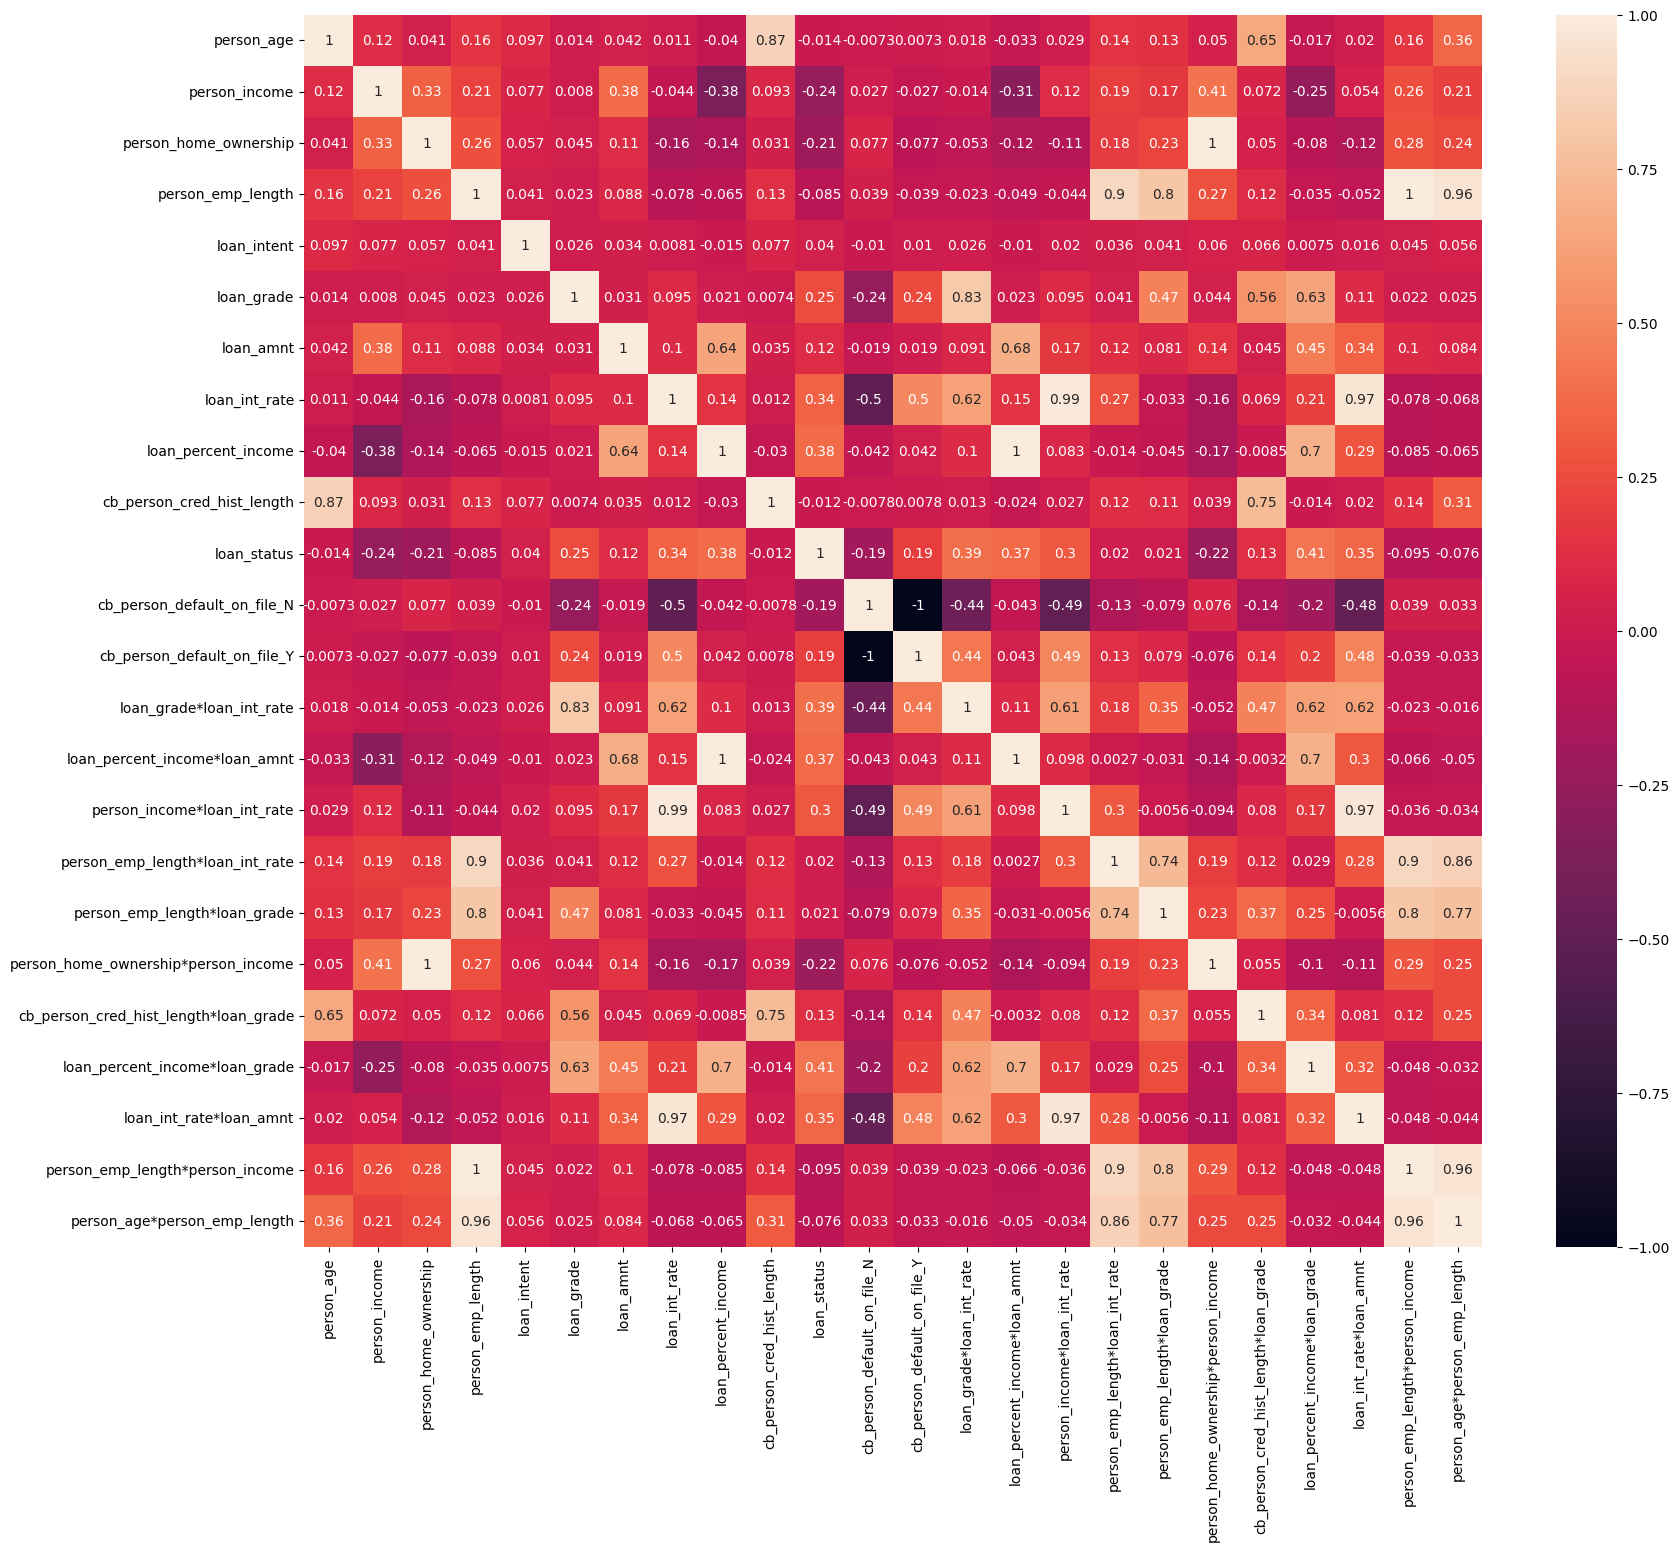

In [37]:
plt.figure(figsize=(19,16))
matrices=train_csv.corr()
sns.heatmap(matrices,annot=True)

In [38]:
for i in train_csv.columns:
    if train_csv[i].dtype=='int64':    
        train_csv[i]=train_csv[i].astype('int32')

In [39]:
for i in cont_var:
    if i=='loan_status':
        continue
    train_csv[i]=train_csv[i].astype('float32')    

In [40]:
y_values=train_csv.pop('loan_status')

In [41]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(train_csv, y_values)

In [42]:
x_train.shape
x_train.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length
count,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,...,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000,77534.000000
mean,27.339363,10.855850,1.738625,4.478341,3.284202,2.545108,9.045727,11.777001,0.197890,5.621626,...,1.838555,127.788826,51.572594,11.286897,19.048891,14.340174,0.502685,106.745010,49.069611,125.777023
std,5.610913,0.489149,0.941134,3.901444,1.564094,1.301558,0.632113,3.330986,0.112104,3.757693,...,1.109871,36.599300,48.749443,12.581866,10.678181,13.119903,0.411435,31.929405,43.398685,127.840263
min,20.000000,9.602450,1.000000,0.000000,1.000000,1.000000,7.208601,5.420000,0.000000,2.000000,...,0.000000,52.330589,0.000000,0.000000,9.602450,2.000000,0.000000,39.070614,0.000000,0.000000
25%,23.000000,10.493656,1.000000,2.000000,2.000000,1.000000,8.613853,8.940000,0.110000,3.000000,...,0.936913,98.896118,15.760000,3.000000,10.596660,6.000000,0.200000,81.399513,19.725435,42.312140
50%,25.772221,10.827766,1.000000,4.000000,3.000000,3.000000,9.124332,11.830000,0.177197,4.000000,...,1.610823,128.508667,39.400002,8.000000,11.122975,10.000000,0.374814,107.545250,41.299088,96.000000
75%,30.000000,11.156265,3.000000,7.000000,4.744161,4.000000,9.520157,14.420000,0.280000,8.000000,...,2.628449,155.257111,74.129997,16.000000,32.502294,18.000000,0.689985,129.708298,72.663933,165.000000
max,57.000000,13.762111,4.000000,26.000000,6.000000,7.000000,10.463132,23.219999,0.720000,27.000000,...,7.122979,282.589783,423.540009,126.000000,53.218746,130.000000,3.840000,232.435501,327.900055,1296.000000


In [43]:
isolation_forest = IsolationForest(contamination='auto', random_state=42)
isolation_forest.fit(x_train) 
x_train['anomaly_scores'] = isolation_forest.decision_function(x_train)
x_train.head(30)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length,anomaly_scores
0,37.0,10.463132,1.0,0.0,1.0,1.0,8.699681,11.49,0.17,14.0,...,120.221382,0.000000,0.0,10.463132,14.0,0.17,99.959343,0.000000,0.0,0.044138
1,22.0,10.933125,2.0,6.0,2.0,2.0,8.294300,13.35,0.07,2.0,...,145.957214,80.099998,12.0,21.866249,4.0,0.14,110.728897,65.598747,132.0,0.046126
2,29.0,10.268166,2.0,8.0,3.0,3.0,8.699681,8.90,0.21,10.0,...,91.386673,71.199997,24.0,20.536331,30.0,0.63,77.427162,82.145325,232.0,0.020576
3,30.0,11.156265,1.0,14.0,4.0,1.0,9.392745,11.11,0.17,5.0,...,123.946098,155.539993,14.0,11.156265,5.0,0.17,104.353401,156.187714,420.0,0.004602
4,22.0,11.002116,1.0,2.0,2.0,3.0,8.699681,6.92,0.10,3.0,...,76.134644,13.840000,6.0,11.002116,9.0,0.30,60.201794,22.004232,44.0,0.074070
5,27.0,10.714440,1.0,2.0,4.0,3.0,9.105091,8.94,0.20,5.0,...,95.787094,17.879999,6.0,10.714440,15.0,0.60,81.399513,21.428881,54.0,0.088249
6,25.0,10.714440,3.0,9.0,1.0,3.0,9.392745,6.54,0.27,3.0,...,70.072441,58.860001,27.0,32.143318,9.0,0.81,61.428555,96.429962,225.0,0.030286
7,21.0,9.903538,1.0,0.0,3.0,2.0,7.824446,13.49,0.13,3.0,...,133.598724,0.000000,0.0,9.903538,6.0,0.26,105.551773,0.000000,0.0,0.011557
8,37.0,11.150535,1.0,11.0,1.0,4.0,8.517393,14.84,0.07,11.0,...,165.473923,163.240005,44.0,11.150535,44.0,0.28,126.398117,122.655876,407.0,-0.063401
9,35.0,11.608245,3.0,0.0,5.0,2.0,9.615872,12.98,0.14,6.0,...,150.675018,0.000000,0.0,34.824734,12.0,0.28,124.814018,0.000000,0.0,-0.005826


In [44]:
scaler=RobustScaler()
columns_to_scale = [col for col in x_train.columns if col != 'anomaly_scores']
x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_train.head(30)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length,anomaly_scores
0,1.603969,-0.550301,0.0,-0.8,-0.72882,-0.666667,-0.468553,-0.062044,-0.042333,2.0,...,-0.147039,-0.675004,-0.615385,-0.030122,0.333333,-0.418002,-0.157030,-0.780133,-0.782474,0.044138
1,-0.538889,0.159005,0.5,0.4,-0.36441,-0.333333,-0.915844,0.277372,-0.630568,-0.4,...,0.309586,0.697276,0.307692,0.490434,-0.500000,-0.479228,0.065902,0.459017,0.293428,0.046126
2,0.461111,-0.844542,0.5,0.8,0.00000,0.000000,-0.468553,-0.534672,0.192961,1.2,...,-0.658647,0.544800,1.230769,0.429723,1.666667,0.520803,-0.623450,0.771579,1.108504,0.020576
3,0.603969,0.495766,0.0,2.0,0.36441,-0.666667,0.296162,-0.131387,-0.042333,0.2,...,-0.080953,1.989721,0.461538,0.001520,-0.416667,-0.418002,-0.066072,2.170228,2.640848,0.004602
4,-0.538889,0.263126,0.0,-0.4,-0.36441,0.000000,-0.468553,-0.895985,-0.454098,-0.2,...,-0.929260,-0.437896,-0.153846,-0.005517,-0.083333,-0.152687,-0.980018,-0.364477,-0.423840,0.074070
5,0.175397,-0.171030,0.0,-0.4,0.36441,0.000000,-0.021231,-0.527372,0.134138,0.2,...,-0.580571,-0.368683,-0.153846,-0.018650,0.416667,0.459577,-0.541221,-0.375345,-0.342332,0.088249
6,-0.110317,-0.171030,1.0,1.0,-0.72882,0.000000,0.296162,-0.965328,0.545902,-0.2,...,-1.036820,0.333390,1.461538,0.959586,-0.083333,0.888161,-0.954623,1.041414,1.051449,0.030286
7,-0.681746,-1.394833,0.0,-0.8,0.00000,-0.333333,-1.434273,0.302920,-0.277627,-0.2,...,0.090312,-0.675004,-0.615385,-0.055668,-0.333333,-0.234323,-0.041265,-0.780133,-0.782474,0.011557
8,1.603969,0.487117,0.0,1.4,-0.72882,0.333333,-0.669686,0.549270,-0.630568,1.4,...,0.655866,2.121638,2.769231,0.001258,2.833333,-0.193505,0.390258,1.536817,2.534888,-0.063401
9,1.318254,1.177887,1.0,-0.8,0.72882,-0.333333,0.542357,0.209854,-0.218804,0.4,...,0.393292,-0.675004,-0.615385,1.081994,0.166667,-0.193505,0.357466,-0.780133,-0.782474,-0.005826


In [45]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
77529    1
77530    1
77531    1
77532    1
77533    1
Name: loan_status, Length: 77534, dtype: int32

In [46]:
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.3,random_state=42,shuffle=True)

In [47]:
scorer=make_scorer(matthews_corrcoef)

In [48]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)}
    model=XGBClassifier(**params)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring='average_precision')
    score=np.mean(score)
    return score

In [49]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

[I 2024-10-13 16:15:07,597] A new study created in memory with name: no-name-78ceca94-3b75-47bc-8319-cf5734a0090b
/tmp/ipykernel_24/3024034674.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:15:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:15:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to

In [50]:
{'booster': 'gbtree', 'tree_method': 'gpu_hist', 'learning_rate': 0.025012252584417916, 'n_estimators': 473, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.781907885806504, 'colsample_bytree': 0.7989438974935437}

{'booster': 'gbtree',
 'tree_method': 'gpu_hist',
 'learning_rate': 0.025012252584417916,
 'n_estimators': 473,
 'max_depth': 8,
 'min_child_weight': 6,
 'subsample': 0.781907885806504,
 'colsample_bytree': 0.7989438974935437}

In [51]:
best_param=study.best_params
print(best_param)

{'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.04667643589096646, 'n_estimators': 456, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8687113947460202, 'colsample_bytree': 0.7340190131614434}


**Chosen Param for Xgboost**

In [52]:
xgb_best_param={'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.07053143003789317, 'n_estimators': 495, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.9552196509544721, 'colsample_bytree': 0.7063869819887866}

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [55]:
xgb_model=XGBClassifier(**xgb_best_param)
xgb_model.fit(x_train,y_train)
y_predict=xgb_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:49:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.9612656377627788


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:50:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Text(0, 0.5, 'recall')

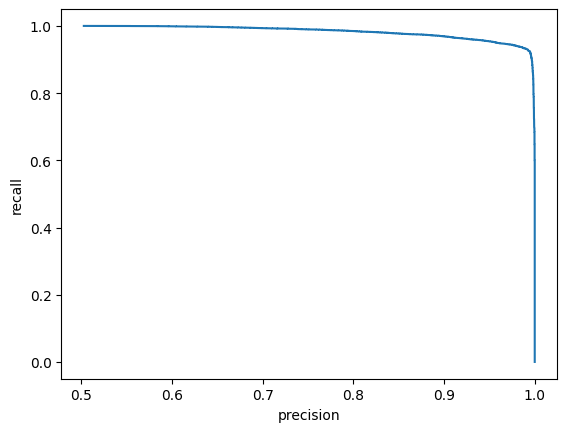

In [56]:
precision,recall,threshold=precision_recall_curve(y_cv,xgb_model.predict_proba(x_cv)[:,1])
plt.plot(precision,recall)
plt.xlabel('precision')
plt.ylabel('recall')

In [57]:
auc=average_precision_score(y_cv,xgb_model.predict_proba(x_cv)[:,1])
print(auc)

0.9910620903740476


<Axes: xlabel='importance', ylabel='feature'>

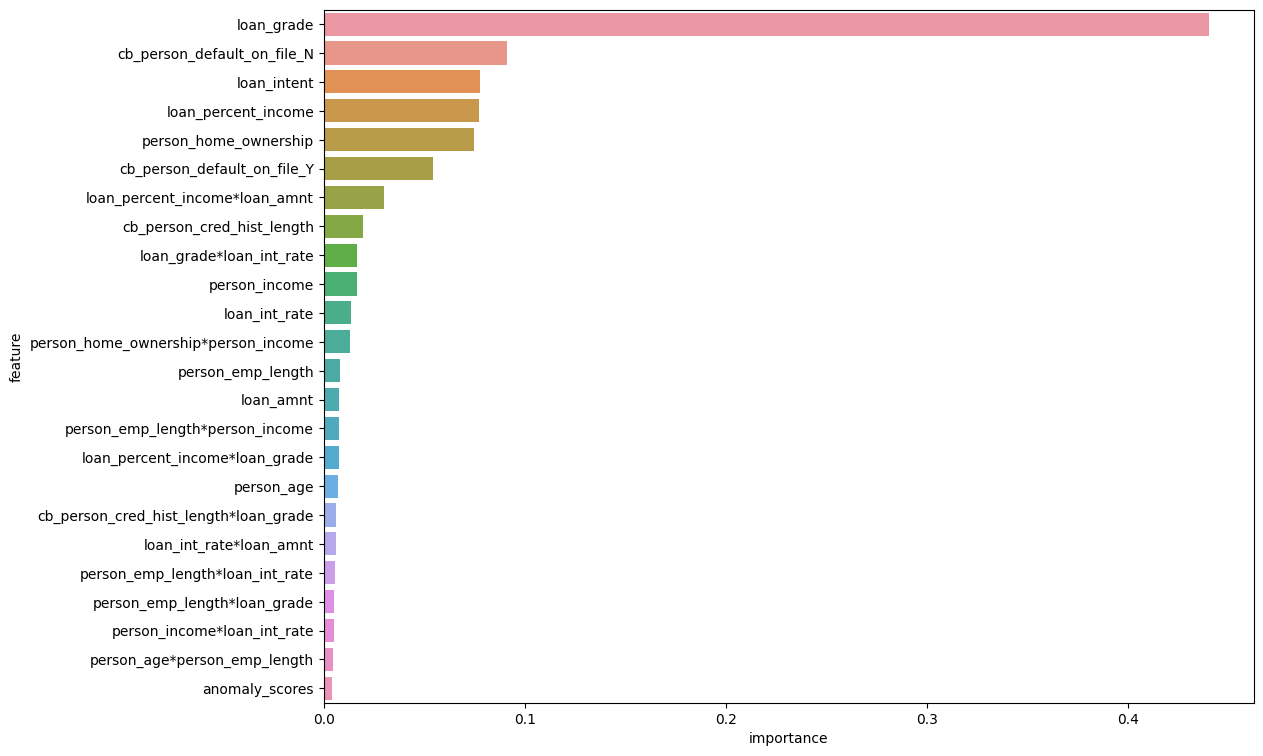

In [58]:
feature_name=xgb_model.feature_names_in_
feature_importance=xgb_model.feature_importances_
x_gbplot=pd.DataFrame({
    'feature':feature_name,
    'importance':feature_importance
})
x_gbplot=x_gbplot.sort_values(by='importance',ascending=False)
plt.figure(figsize=(12,9))
sns.barplot(x=x_gbplot['importance'],y=x_gbplot['feature'],data=x_gbplot)

In [59]:
isolation_forest.fit(train_csv) 
train_csv['anomaly_scores'] = isolation_forest.decision_function(train_csv)
train_csv.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length,anomaly_scores
0,37.0,10.463132,1.0,0.0,1.0,1.0,8.699681,11.49,0.17,14.0,...,120.221382,0.000000,0.0,10.463132,14.0,0.17,99.959343,0.000000,0.0,0.056138
1,22.0,10.933125,2.0,6.0,2.0,2.0,8.294300,13.35,0.07,2.0,...,145.957214,80.099998,12.0,21.866249,4.0,0.14,110.728897,65.598747,132.0,0.071207
2,29.0,10.268166,2.0,8.0,3.0,3.0,8.699681,8.90,0.21,10.0,...,91.386673,71.199997,24.0,20.536331,30.0,0.63,77.427162,82.145325,232.0,0.037336
3,30.0,11.156265,1.0,14.0,4.0,1.0,9.392745,11.11,0.17,5.0,...,123.946098,155.539993,14.0,11.156265,5.0,0.17,104.353401,156.187714,420.0,0.034610
4,22.0,11.002116,1.0,2.0,2.0,3.0,8.699681,6.92,0.10,3.0,...,76.134644,13.840000,6.0,11.002116,9.0,0.30,60.201794,22.004232,44.0,0.091891
5,27.0,10.714440,1.0,2.0,4.0,3.0,9.105091,8.94,0.20,5.0,...,95.787094,17.879999,6.0,10.714440,15.0,0.60,81.399513,21.428881,54.0,0.099120
6,25.0,10.714440,3.0,9.0,1.0,3.0,9.392745,6.54,0.27,3.0,...,70.072441,58.860001,27.0,32.143318,9.0,0.81,61.428555,96.429962,225.0,0.020770
7,21.0,9.903538,1.0,0.0,3.0,2.0,7.824446,13.49,0.13,3.0,...,133.598724,0.000000,0.0,9.903538,6.0,0.26,105.551773,0.000000,0.0,0.004094
8,37.0,11.150535,1.0,11.0,1.0,4.0,8.517393,14.84,0.07,11.0,...,165.473923,163.240005,44.0,11.150535,44.0,0.28,126.398117,122.655876,407.0,-0.084569
9,35.0,11.608245,3.0,0.0,5.0,2.0,9.615872,12.98,0.14,6.0,...,150.675018,0.000000,0.0,34.824734,12.0,0.28,124.814018,0.000000,0.0,-0.016598


In [60]:
columns_to_scale = [col for col in train_csv.columns if col != 'anomaly_scores']
train_csv[columns_to_scale] = scaler.transform(train_csv[columns_to_scale])
train_csv.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length,anomaly_scores
0,1.603969,-0.550301,0.0,-0.8,-0.72882,-0.666667,-0.468553,-0.062044,-0.042333,2.0,...,-0.147039,-0.675004,-0.615385,-0.030122,0.333333,-0.418002,-0.157030,-0.780133,-0.782474,0.056138
1,-0.538889,0.159005,0.5,0.4,-0.36441,-0.333333,-0.915844,0.277372,-0.630568,-0.4,...,0.309586,0.697276,0.307692,0.490434,-0.500000,-0.479228,0.065902,0.459017,0.293428,0.071207
2,0.461111,-0.844542,0.5,0.8,0.00000,0.000000,-0.468553,-0.534672,0.192961,1.2,...,-0.658647,0.544800,1.230769,0.429723,1.666667,0.520803,-0.623450,0.771579,1.108504,0.037336
3,0.603969,0.495766,0.0,2.0,0.36441,-0.666667,0.296162,-0.131387,-0.042333,0.2,...,-0.080953,1.989721,0.461538,0.001520,-0.416667,-0.418002,-0.066072,2.170228,2.640848,0.034610
4,-0.538889,0.263126,0.0,-0.4,-0.36441,0.000000,-0.468553,-0.895985,-0.454098,-0.2,...,-0.929260,-0.437896,-0.153846,-0.005517,-0.083333,-0.152687,-0.980018,-0.364477,-0.423840,0.091891
5,0.175397,-0.171030,0.0,-0.4,0.36441,0.000000,-0.021231,-0.527372,0.134138,0.2,...,-0.580571,-0.368683,-0.153846,-0.018650,0.416667,0.459577,-0.541221,-0.375345,-0.342332,0.099120
6,-0.110317,-0.171030,1.0,1.0,-0.72882,0.000000,0.296162,-0.965328,0.545902,-0.2,...,-1.036820,0.333390,1.461538,0.959586,-0.083333,0.888161,-0.954623,1.041414,1.051449,0.020770
7,-0.681746,-1.394833,0.0,-0.8,0.00000,-0.333333,-1.434273,0.302920,-0.277627,-0.2,...,0.090312,-0.675004,-0.615385,-0.055668,-0.333333,-0.234323,-0.041265,-0.780133,-0.782474,0.004094
8,1.603969,0.487117,0.0,1.4,-0.72882,0.333333,-0.669686,0.549270,-0.630568,1.4,...,0.655866,2.121638,2.769231,0.001258,2.833333,-0.193505,0.390258,1.536817,2.534888,-0.084569
9,1.318254,1.177887,1.0,-0.8,0.72882,-0.333333,0.542357,0.209854,-0.218804,0.4,...,0.393292,-0.675004,-0.615385,1.081994,0.166667,-0.193505,0.357466,-0.780133,-0.782474,-0.016598


In [61]:
y_predict=xgb_model.predict(train_csv)
accuracy=accuracy_score(y_values,y_predict)
print(accuracy)

0.9759442209255788


In [62]:
auc=average_precision_score(y_values,xgb_model.predict_proba(train_csv)[:,1])
print(auc)

0.9716292510911358


In [63]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [64]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 200, 500),
        'depth': trial.suggest_int('depth', 5, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 10.0),
    }
    model = CatBoostClassifier(**param,verbose=0)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring='average_precision')
    score=np.mean(score)
    return score


In [65]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

[I 2024-10-13 18:50:46,268] A new study created in memory with name: no-name-ecf17d44-3d38-4585-b4bb-6be2e12552ab
/tmp/ipykernel_24/4274354854.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
/tmp/ipykernel_24/4274354854.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
/tmp/ipykernel_24/4274354854.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temper

In [66]:
best_param=study.best_params
print(best_param)

{'iterations': 448, 'depth': 8, 'learning_rate': 0.099461693703333, 'l2_leaf_reg': 0.3266640374545538, 'border_count': 227, 'bagging_temperature': 0.28594521953962404, 'random_strength': 4.529992026210704}


In [67]:
cat_param={'iterations': 403, 'depth': 8, 'learning_rate': 0.08661900351855881, 'l2_leaf_reg': 0.3340158288147267, 'border_count': 161, 'bagging_temperature': 0.6558331262419914, 'random_strength': 5.971771501592824}

In [68]:
cat_model=CatBoostClassifier(**cat_param)
cat_model.fit(x_train,y_train)
y_predict=cat_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

0:	learn: 0.6352389	total: 19ms	remaining: 7.65s
1:	learn: 0.5959515	total: 37.6ms	remaining: 7.53s
2:	learn: 0.5587662	total: 56.8ms	remaining: 7.57s
3:	learn: 0.5085439	total: 74.9ms	remaining: 7.47s
4:	learn: 0.4819722	total: 93.8ms	remaining: 7.47s
5:	learn: 0.4578307	total: 113ms	remaining: 7.49s
6:	learn: 0.4447856	total: 132ms	remaining: 7.48s
7:	learn: 0.4317352	total: 151ms	remaining: 7.45s
8:	learn: 0.4123582	total: 169ms	remaining: 7.41s
9:	learn: 0.3972158	total: 189ms	remaining: 7.43s
10:	learn: 0.3739055	total: 208ms	remaining: 7.4s
11:	learn: 0.3597994	total: 227ms	remaining: 7.4s
12:	learn: 0.3536464	total: 249ms	remaining: 7.47s
13:	learn: 0.3454710	total: 269ms	remaining: 7.49s
14:	learn: 0.3415323	total: 290ms	remaining: 7.49s
15:	learn: 0.3361157	total: 309ms	remaining: 7.47s
16:	learn: 0.3310738	total: 328ms	remaining: 7.44s
17:	learn: 0.3267484	total: 347ms	remaining: 7.43s
18:	learn: 0.3163694	total: 367ms	remaining: 7.41s
19:	learn: 0.3138819	total: 385ms	remain

In [69]:
auc=average_precision_score(y_cv,cat_model.predict_proba(x_cv)[:,1])
print(auc)

0.9898820926492432


In [70]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'verbosity':-1,
    }
    model = LGBMClassifier(**param,verbose=0)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring='average_precision')
    score=np.mean(score)
    return score 


In [71]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

[I 2024-10-13 19:30:42,335] A new study created in memory with name: no-name-d462d4ca-5f7c-4ac4-9b83-6668b8443137
/tmp/ipykernel_24/272526099.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipykernel_24/272526099.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipykernel_24/272526099.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1

In [72]:
lgb_param=study.best_params
print(lgb_param)

{'num_leaves': 140, 'max_depth': 8, 'learning_rate': 0.09291286183660867, 'n_estimators': 355, 'subsample': 0.8310686953526017, 'colsample_bytree': 0.6816437917335688, 'min_child_samples': 21, 'reg_alpha': 0.3335573945189294, 'reg_lambda': 2.7613644037204457e-08}


In [73]:
lgb_param={'num_leaves': 114, 'max_depth': 8, 'learning_rate': 0.09822595208510619, 'n_estimators': 473, 'subsample': 0.9347836958422833, 'colsample_bytree': 0.854452405006727, 'min_child_samples': 28, 'reg_alpha': 6.379245798884508e-07, 'reg_lambda': 1.6680281655620879}

In [74]:
lgb_model=LGBMClassifier(**lgb_param)
lgb_model.fit(x_train,y_train)
y_predict=lgb_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

[LightGBM] [Info] Number of positive: 27075, number of negative: 27198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5582
[LightGBM] [Info] Number of data points in the train set: 54273, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498867 -> initscore=-0.004533
[LightGBM] [Info] Start training from score -0.004533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [75]:
auc=average_precision_score(y_cv,lgb_model.predict_proba(x_cv)[:,1])
print(auc)

0.9913034626351673


In [76]:
from sklearn.ensemble import VotingClassifier

In [77]:
voting_model = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('lgbm', lgb_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  
)

In [78]:
voting_model.fit(x_train,y_train)
y_predict=voting_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

0:	learn: 0.6352389	total: 18.9ms	remaining: 7.6s
1:	learn: 0.5959515	total: 37ms	remaining: 7.41s
2:	learn: 0.5587662	total: 55.3ms	remaining: 7.38s
3:	learn: 0.5085439	total: 73.6ms	remaining: 7.34s
4:	learn: 0.4819722	total: 92.8ms	remaining: 7.38s
5:	learn: 0.4578307	total: 112ms	remaining: 7.42s
6:	learn: 0.4447856	total: 130ms	remaining: 7.37s
7:	learn: 0.4317352	total: 149ms	remaining: 7.37s
8:	learn: 0.4123582	total: 167ms	remaining: 7.3s
9:	learn: 0.3972158	total: 185ms	remaining: 7.27s
10:	learn: 0.3739055	total: 203ms	remaining: 7.25s
11:	learn: 0.3597994	total: 222ms	remaining: 7.23s
12:	learn: 0.3536464	total: 240ms	remaining: 7.21s
13:	learn: 0.3454710	total: 258ms	remaining: 7.18s
14:	learn: 0.3415323	total: 277ms	remaining: 7.17s
15:	learn: 0.3361157	total: 295ms	remaining: 7.13s
16:	learn: 0.3310738	total: 314ms	remaining: 7.14s
17:	learn: 0.3267484	total: 333ms	remaining: 7.12s
18:	learn: 0.3163694	total: 351ms	remaining: 7.09s
19:	learn: 0.3138819	total: 368ms	remain

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:47:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


0.9627273118094665


In [79]:
auc=average_precision_score(y_cv,voting_model.predict_proba(x_cv)[:,1])
print(auc)

0.9914169707827525


In [80]:
test_csv='/kaggle/input/playground-series-s4e10/test.csv'

In [81]:
test_csv=pd.read_csv(test_csv)
test_csv

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
39094,97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
39095,97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25
39096,97741,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4


In [82]:
test_csv.drop_duplicates(inplace=True)

In [83]:
test_csv.shape

(39098, 12)

In [84]:
id=test_csv.pop('id')

In [85]:
test_csv['person_home_ownership']=test_csv['person_home_ownership'].map(house_status)
test_csv['loan_intent']=test_csv['loan_intent'].map(status)
test_csv['loan_grade']=test_csv['loan_grade'].map(grade)

In [86]:
test_csv = pd.get_dummies(test_csv, columns=['cb_person_default_on_file'])
test_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,23,69000,1,3.0,6,6,25000,15.76,0.36,2,True,False
1,26,96000,3,6.0,3,2,10000,12.68,0.10,4,False,True
2,26,30000,1,5.0,4,5,4000,17.19,0.13,2,False,True
3,33,50000,1,4.0,5,3,7000,8.90,0.14,7,True,False
4,26,102000,3,8.0,6,4,15000,16.32,0.15,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,22,31200,3,2.0,5,1,3000,10.37,0.10,4,True,False
39094,22,48000,3,6.0,1,3,7000,6.03,0.15,3,True,False
39095,51,60000,3,0.0,3,3,15000,7.51,0.25,25,True,False
39096,22,36000,3,4.0,3,4,14000,15.62,0.39,4,False,True


In [87]:
test_csv['loan_grade*loan_int_rate']=test_csv['loan_grade']*test_csv['loan_int_rate']
test_csv['loan_percent_income*loan_amnt']=test_csv['loan_percent_income']*test_csv['loan_amnt']
test_csv['person_income*loan_int_rate']=test_csv['person_income']*test_csv['loan_int_rate']
test_csv['person_emp_length*loan_int_rate']=test_csv['person_emp_length']*test_csv['loan_int_rate']
test_csv['person_emp_length*loan_grade']=test_csv['person_emp_length']*test_csv['loan_grade']
test_csv['person_home_ownership*person_income']=test_csv['person_home_ownership']*test_csv['person_income']
test_csv['cb_person_cred_hist_length*loan_grade']=test_csv['cb_person_cred_hist_length']*test_csv['loan_grade']
test_csv['loan_percent_income*loan_grade']=test_csv['loan_percent_income']*test_csv['loan_grade']
test_csv['loan_int_rate*loan_amnt']=test_csv['loan_int_rate']*test_csv['loan_amnt']
test_csv['person_emp_length*person_income']=test_csv['person_emp_length']*test_csv['person_income']
test_csv['person_age*person_emp_length']=test_csv['person_emp_length']*test_csv['person_age']

In [88]:
for i in cont_var:
    if i=='loan_status':
        continue
    test_csv[i]=test_csv[i].astype('float32')    

In [89]:
test_csv

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,loan_percent_income*loan_amnt,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length
0,23.0,69000.0,1.0,3.0,6.0,6.0,25000.0,15.760000,0.36,2.0,...,9000.0,1087440.0,47.279999,18.0,69000.0,12.0,2.16,394000.0,207000.0,69.0
1,26.0,96000.0,3.0,6.0,3.0,2.0,10000.0,12.680000,0.10,4.0,...,1000.0,1217280.0,76.080002,12.0,288000.0,8.0,0.20,126800.0,576000.0,156.0
2,26.0,30000.0,1.0,5.0,4.0,5.0,4000.0,17.190001,0.13,2.0,...,520.0,515700.0,85.949997,25.0,30000.0,10.0,0.65,68760.0,150000.0,130.0
3,33.0,50000.0,1.0,4.0,5.0,3.0,7000.0,8.900000,0.14,7.0,...,980.0,445000.0,35.599998,12.0,50000.0,21.0,0.42,62300.0,200000.0,132.0
4,26.0,102000.0,3.0,8.0,6.0,4.0,15000.0,16.320000,0.15,4.0,...,2250.0,1664640.0,130.559998,32.0,306000.0,16.0,0.60,244800.0,816000.0,208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,22.0,31200.0,3.0,2.0,5.0,1.0,3000.0,10.370000,0.10,4.0,...,300.0,323544.0,20.740000,2.0,93600.0,4.0,0.10,31110.0,62400.0,44.0
39094,22.0,48000.0,3.0,6.0,1.0,3.0,7000.0,6.030000,0.15,3.0,...,1050.0,289440.0,36.180000,18.0,144000.0,9.0,0.45,42210.0,288000.0,132.0
39095,51.0,60000.0,3.0,0.0,3.0,3.0,15000.0,7.510000,0.25,25.0,...,3750.0,450600.0,0.000000,0.0,180000.0,75.0,0.75,112650.0,0.0,0.0
39096,22.0,36000.0,3.0,4.0,3.0,4.0,14000.0,15.620000,0.39,4.0,...,5460.0,562320.0,62.480000,16.0,108000.0,16.0,1.56,218680.0,144000.0,88.0


In [90]:
isolation_forest.fit(test_csv) 
test_csv['anomaly_scores'] = isolation_forest.decision_function(test_csv)
test_csv.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length,anomaly_scores
0,23.0,69000.0,1.0,3.0,6.0,6.0,25000.0,15.760000,0.36,2.0,...,1087440.000,47.279999,18.0,69000.0,12.0,2.16,394000.0,207000.0,69.0,-0.107672
1,26.0,96000.0,3.0,6.0,3.0,2.0,10000.0,12.680000,0.10,4.0,...,1217280.000,76.080002,12.0,288000.0,8.0,0.20,126800.0,576000.0,156.0,0.020486
2,26.0,30000.0,1.0,5.0,4.0,5.0,4000.0,17.190001,0.13,2.0,...,515700.000,85.949997,25.0,30000.0,10.0,0.65,68760.0,150000.0,130.0,-0.053215
3,33.0,50000.0,1.0,4.0,5.0,3.0,7000.0,8.900000,0.14,7.0,...,445000.000,35.599998,12.0,50000.0,21.0,0.42,62300.0,200000.0,132.0,0.101353
4,26.0,102000.0,3.0,8.0,6.0,4.0,15000.0,16.320000,0.15,4.0,...,1664640.000,130.559998,32.0,306000.0,16.0,0.60,244800.0,816000.0,208.0,-0.079732
5,23.0,66000.0,1.0,5.0,1.0,4.0,22000.0,14.090000,0.33,2.0,...,929940.000,70.449997,20.0,66000.0,8.0,1.32,309980.0,330000.0,115.0,-0.040222
6,26.0,75000.0,2.0,10.0,3.0,1.0,8000.0,10.620000,0.11,4.0,...,796500.000,106.199997,10.0,150000.0,4.0,0.11,84960.0,750000.0,260.0,0.083117
7,23.0,55000.0,3.0,6.0,3.0,3.0,6250.0,6.760000,0.12,2.0,...,371800.000,40.560001,18.0,165000.0,6.0,0.36,42250.0,330000.0,138.0,0.113327
8,32.0,29124.0,1.0,0.0,3.0,2.0,7200.0,13.110000,0.26,6.0,...,381815.625,0.000000,0.0,29124.0,12.0,0.52,94392.0,0.0,0.0,0.012387
9,22.0,90000.0,1.0,4.0,5.0,2.0,10000.0,13.490000,0.11,3.0,...,1214100.000,53.959999,8.0,90000.0,6.0,0.22,134900.0,360000.0,88.0,0.023987


In [91]:
columns_to_scale = [col for col in test_csv.columns if col != 'anomaly_scores']
test_csv[columns_to_scale] = scaler.transform(test_csv[columns_to_scale])
test_csv.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,...,person_income*loan_int_rate,person_emp_length*loan_int_rate,person_emp_length*loan_grade,person_home_ownership*person_income,cb_person_cred_hist_length*loan_grade,loan_percent_income*loan_grade,loan_int_rate*loan_amnt,person_emp_length*person_income,person_age*person_emp_length,anomaly_scores
0,-0.396032,104117.492188,0.0,-0.2,1.09323,1.000000,27574.505859,0.717153,1.075314,-0.4,...,19291.916016,0.135001,0.769231,3149.366699,0.166667,3.643350,8153.640625,3909.417725,-0.220071,-0.107672
1,0.032540,144865.515625,1.0,0.4,0.00000,-0.333333,11023.762695,0.155110,-0.454098,0.0,...,21595.636719,0.628405,0.307692,13146.794922,-0.166667,-0.356775,2622.555176,10879.770508,0.489046,0.020486
2,0.032540,45259.238281,0.0,0.2,0.36441,0.666667,4403.464355,0.978102,-0.277627,-0.4,...,9147.665039,0.797499,1.307692,1369.002930,0.000000,0.561621,1421.117432,2832.696533,0.277126,-0.053215
3,1.032540,75442.953125,0.0,0.0,0.72882,0.000000,7713.612793,-0.534672,-0.218804,0.6,...,7893.251953,-0.065102,0.307692,2282.010254,0.916667,0.092218,1287.394287,3777.188965,0.293428,0.101353
4,0.032540,153920.625000,1.0,0.8,1.09323,0.333333,16540.677734,0.819343,-0.159980,0.0,...,29533.041016,1.561761,1.846154,13968.500977,0.500000,0.459577,5065.175293,15413.333008,0.912886,-0.079732
5,-0.396032,99589.929688,0.0,0.2,-0.72882,0.333333,24264.357422,0.412409,0.898844,-0.4,...,16497.429688,0.531951,0.923077,3012.415771,-0.166667,1.929010,6414.412598,6232.868164,0.154865,-0.040222
6,0.032540,113172.609375,0.5,1.2,0.00000,-0.666667,8816.996094,-0.220803,-0.395274,0.0,...,14129.834961,1.144423,0.153846,6847.045410,-0.500000,-0.540455,1756.460083,14166.603516,1.336726,0.083117
7,-0.396032,82988.890625,1.0,0.4,0.00000,0.000000,6886.075684,-0.925182,-0.336451,-0.4,...,6594.480957,0.019873,0.769231,7531.800781,-0.333333,-0.030234,872.355896,6232.868164,0.342332,0.113327
8,0.889683,43937.191406,0.0,-0.8,0.00000,-0.333333,7934.289551,0.233577,0.487079,0.4,...,6772.186035,-0.675004,-0.615385,1329.013184,0.166667,0.296306,1951.704102,-0.780133,-0.782474,0.012387
9,-0.538889,135810.390625,0.0,0.0,0.72882,-0.333333,11023.762695,0.302920,-0.395274,-0.2,...,21539.214844,0.249443,0.000000,4108.024414,-0.333333,-0.315958,2790.226562,6799.563965,-0.065206,0.023987


In [92]:
y_test=voting_model.predict(test_csv)

In [93]:
y_test

array([1, 0, 0, ..., 0, 0, 1], dtype=int32)

In [94]:
subnit_df=pd.DataFrame({
    'id':id,
    'loan_status':y_test
})

In [95]:
subnit_df

,id,loan_status
0,58645,1
1,58646,0
2,58647,0
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0


In [96]:
subnit_df.to_csv('my_submission.csv',index=False)